# Quantum Parallelism and Deutsch Joshua (DJ) Algorithm

## Quantum Parallelism

In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

QP arises because of the fact that we can feed superposition state at once and get superposition output. Let us assume a Boolean function which does this:

$f:\{0,1\} -> {\{0,1}\}$

We can create a circuit which does this:

$U_{f}:|x,y> -> |x,y\oplus f(x)>$

Once a circuit like this is applied, the output can be used to determine the nature of the Boolean function.

## DJ Algorithm

### DJ Problem

We are given a hidden Boolean function  f , which takes as input a string of bits, and returns either  0  or  1 , that is:
    $f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all  0 's or all  1 's for any input, while a balanced function returns  0 's for exactly half of all inputs and  1 's for the other half.

Our task is to determine whether the given function is balanced or constant.

### Classical Solution to DJ Problem

Let's say we have 4 bits. Four bits will hav3 2^4=16 combinations.

Best case:
Two queries can determine if the hidden Boolean function,  f(x) , is balanced: e.g. if we get both  f(0,0,0,...)→0  and  f(1,0,0,...)→1 , then we know the function is balanced as we have obtained the two different outputs.
Worst case:
If we continue to see the same output for each input we try we need to run the query (N/2)+1=4 times to know if the funtion is balanced or constant.



### Quantum Solution:

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function  f(x) , provided we have the function  f  implemented as a quantum oracle, which maps the state  |x⟩|y⟩  to  |x⟩|y⊕f(x)⟩ , where  ⊕  is addition modulo  2 .

![DJCircuit](DJCircuit.PNG)

Steps:
 Prepare two quantum registers. The first is an  n -qubit register initialised to  |0⟩ , and the second is a one-qubit register initialised to  |1⟩ :
 
$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$
 
Apply a Hadamard gate to each qubit:

$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$
 
Apply the quantum oracle  |x⟩|y⟩  to  |x⟩|y⊕f(x)⟩ :

$\begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}$
 
since for each  x,f(x)  is either  0  or  1 .
At this point the second single qubit register may be ignored. Apply a Hadamard gate to each qubit in the first register:

$\begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned}$ 
        
where  $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$  is the sum of the bitwise product.
Measure the first register. Notice that the probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$  , which evaluates to  1  if  f(x)  is constant and  0  if  f(x)  is balanced.
   

## DJ in Qiskit 

In [2]:
n=3

### Creating Constant Oracle

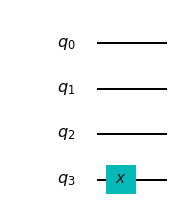

In [3]:
#When the oracle is constant, it has no effect (up to a global phase)
#on the input qubits, and the quantum states
#before and after querying the oracle are the same.

# set the length of the n-bit input string. 
const_oracle = QuantumCircuit(n+1)
#randomly set output qubit to be 0 or 1
output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw(output='mpl')

### Creating Balanced Oracle

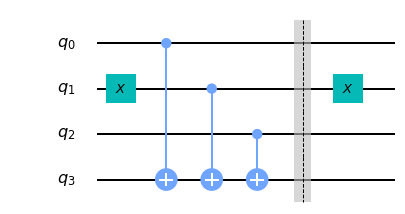

In [4]:
#we can create a balanced oracle by performing CNOTs with
#each input qubit as a control and the output bit as the target.
balanced_oracle = QuantumCircuit(n+1)
#We can vary the input states that give 0 or 1 by wrapping some of the
#controls in X-gates. Let's first choose a binary string of length n that
#dictates which controls to wrap:
b_str='010'
# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
# Now we add our controlled NOT gate
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
#balanced_oracle.draw(output='mpl')
#Finally, we repeat the code
#from two cells up to finish wrapping the controls in X-gates:
# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw(output='mpl')

### Apply balanced Oracle in 3 qubit

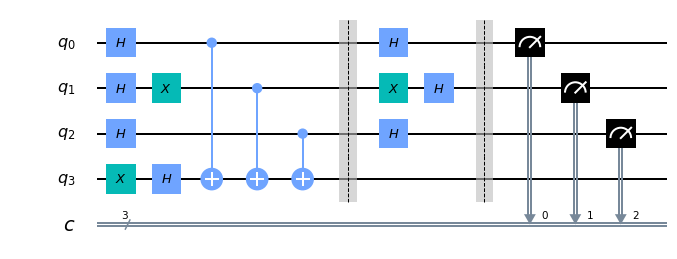

In [5]:
#Let's apply balanced Oracale on 3 qubits
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put  last qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw(output='mpl')

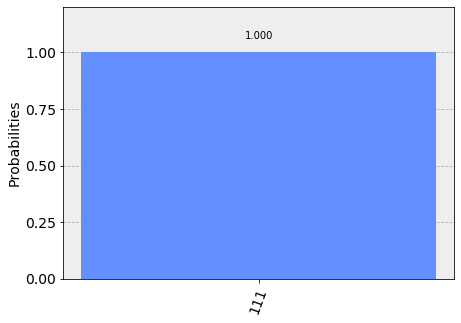

In [6]:
# Check Output
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [7]:
#We can see from the result that we have 0% chance of measuring 000.
#This correctly predicts the function is balanced.
'''Explanation: Hadamard Combined with CNOT is a phase kickback circuit.
So, when the Oracle is balanced, phase kickback adds a negative phase to
exactly half of these states. 
Thus, we must end up with a quantum state that is orthogonal to
|000...0> state. This means we never measure all-zero state. 
'''

'Explanation: Hadamard Combined with CNOT is a phase kickback circuit.\nSo, when the Oracle is balanced, phase kickback adds a negative phase to\nexactly half of these states. \nThus, we must end up with a quantum state that is orthogonal to\n|000...0> state. This means we never measure all-zero state. \n'

### Applying Constant Oracle in 3 qubits

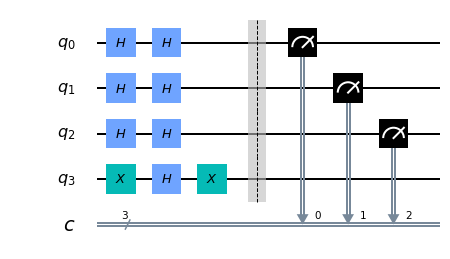

In [8]:
#Let's apply balanced Oracale on 3 qubits
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put  last qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += const_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw(output='mpl')

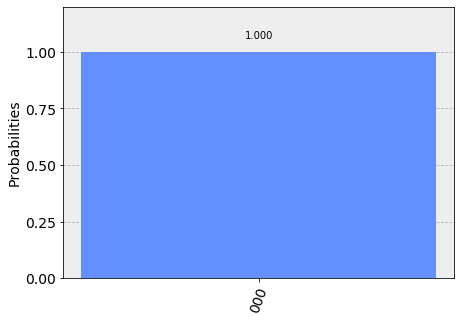

In [9]:
# Check Output
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)